# RECAPを使った分解

In [1]:
import pandas as pd

import rdkit 
from rdkit.Chem import MolFromSmiles, Descriptors

In [5]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['mol'] = df['smiles'].apply(MolFromSmiles)

## ReCAPの階層構造可視化

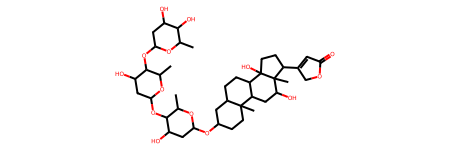

In [6]:
index_maxmolwt = df['mol'].apply(dict(Descriptors.descList)['MolWt']).argmax()
df['mol'].iloc[index_maxmolwt]

In [7]:
base_mol = df['mol'].iloc[index_maxmolwt]

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Recap

In [9]:
decomp = Recap.RecapDecompose(base_mol)
layer1 = [node.mol for node in decomp.children.values()]

## 再帰関数によるSMILESの表示

In [10]:
def dump_leaves(recap_root, n_nests=1):
    for leaf in recap_root.children.values():
        print('  > '*(n_nests-1) + leaf.smiles)
        dump_leaves(leaf, n_nests=n_nests+1)

dump_leaves(decomp)

*C1CC(O)C(O)C(C)O1
*C1C(O)CC(OC2C(O)CC(OC3CCC4(C)C(CCC5C4CC(O)C4(C)C(C6=CC(=O)OC6)CCC54O)C3)OC2C)OC1C
  > *C1CC(O)C(*)C(C)O1
  > *C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C
  >   > *C1CC(O)C(*)C(C)O1
  >   > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
  > *C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
  > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
*C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1
  > *C1CC(O)C(*)C(C)O1
  > *C1CC(O)C(O)C(C)O1
*C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C
  > *C1CC(O)C(*)C(C)O1
  > *C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1
*C1CC(O)C(OC2CC(O)C(OC3CC(O)C(O)C(C)O3)C(C)O2)C(C)O1
  > *C1CC(O)C(*)C(C)O1
  > *C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
  >   > *C1CC(O)C(O)C(C)O1
  > *C1CC(O)C(O)C(C)O1
  > *C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1
  >   > *C1CC(O)C(*)C(C)O1
*C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1


In [11]:
from pprint import pprint

## 取り出したフラグメントの数え上げ

In [12]:
def extract(ret, parent):
    for child in parent.children.values():
        ret += [child.smiles]
        extract(ret, child)
list_recap=[]
extract(list_recap, decomp)
print('取り出された全てのフラグメント', len(set(list_recap)))
pprint(set(list_recap))

取り出された全てのフラグメント 8
{'*C1C(O)CC(OC2C(O)CC(OC3CCC4(C)C(CCC5C4CC(O)C4(C)C(C6=CC(=O)OC6)CCC54O)C3)OC2C)OC1C',
 '*C1C(O)CC(OC2CCC3(C)C(CCC4C3CC(O)C3(C)C(C5=CC(=O)OC5)CCC43O)C2)OC1C',
 '*C1CC(O)C(*)C(C)O1',
 '*C1CC(O)C(O)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(*)C(C)O2)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(O)C(C)O2)C(C)O1',
 '*C1CC(O)C(OC2CC(O)C(OC3CC(O)C(O)C(C)O3)C(C)O2)C(C)O1',
 '*C1CCC2(C)C(CCC3C2CC(O)C2(C)C(C4=CC(=O)OC4)CCC32O)C1'}


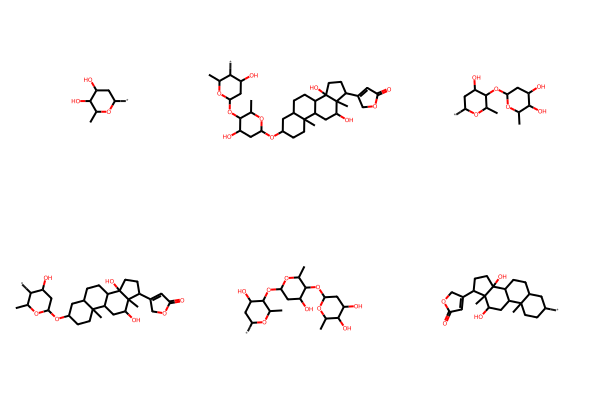

In [13]:
Draw.MolsToGridImage(layer1, molsPerRow=3)

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
molwt = lambda m:dict(Descriptors.descList)['MolWt'](m)

## 分子1構造のRECAPフラグメントネットワークの可視化

... 今回のサンプルでは複数のフラグメントが同じフラグメントに収束することが分かる

In [16]:
D = nx.DiGraph()
from copy import deepcopy 

def grow_leaves(G, parent, n_levels=1):
    if n_levels==1:
        G.add_node(parent.smiles)
    if parent.children:
        for leaf in parent.children.values():
            properties = {
                'smiles':leaf.smiles, 
                'molwt': molwt(leaf.mol),
            }
            G.add_edge(parent.smiles, leaf.smiles,
                       **properties)
            grow_leaves(G, leaf, n_levels+1)
    return G

In [17]:
parent = deepcopy(decomp)
grow_leaves(D, decomp)
print(len(D))

9


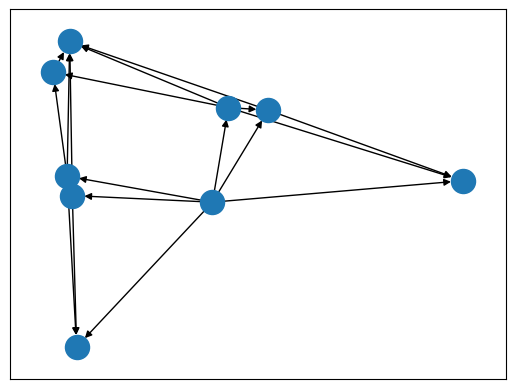

In [18]:
nx.draw_networkx(D,with_labels=False)
plt.show()

In [21]:
colors=['r']+['g']*(len(D)-1)
colors # 木の最初(親ノード)だけを赤、それ以外を緑で色付けする準備

['r', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g']

In [19]:
# list(D)
from rdkit.Chem.Draw import IPythonConsole 

In [20]:
smiles_parent = Chem.MolToSmiles(decomp.mol)
list_sizes=[600 if smi == smiles_parent else 200 for smi in list(D)]

In [21]:
nx.draw_circular(D, node_shape='h', node_size=list_sizes) # node_color=colors, 
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>